In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage  

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
generate_llm = GoogleGenerativeAI(model="gemini-1.5-pro")
evaluate_llm = GoogleGenerativeAI(model="gemini-1.5-pro")
optimizer_llm = GoogleGenerativeAI(model="gemini-1.5-pro")

In [4]:
class PostCreationState(TypedDict):
    topic : str
    content : str
    evaluation : Literal["good", "bad"]
    feedback : str
    iteration: int
    max_iterations: int

In [5]:
def generate(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english.
            """)]
    
    response = generate_llm.invoke(messages)
    state['content'] = response
    return state

In [6]:
def evaluate(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a social media expert."),
        HumanMessage(content=f"""
            Evaluate the following tweet for humor and engagement:
            "{state['content']}"

            Rules:
            - Rate as "good" or "bad".
            - Provide constructive feedback.
            """)]
    
    response = evaluate_llm.invoke(messages)
    state['evaluation'] = response
    state['feedback'] = response
    return state

In [16]:
def optimize(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a social media optimization expert."),
        HumanMessage(content=f"""
            Optimize the following tweet based on feedback:
            "{state['content']}"
            Feedback: "{state['feedback']}"

            Rules:
            - Make it more engaging and humorous.
            - Keep it under 280 characters.
            """)]
    
    response = optimizer_llm.invoke(messages)
    state['content'] = response
    
    if state['evaluation'] == "good" or state['iteration'] >= state['max_iterations']:
        return END(state)
    
    state['iteration'] += 1
    return state

In [17]:
def route_evaluation(state: PostCreationState):
    if state['evaluation'] == "good" or state['iteration'] >= state['max_iterations']:
        return 'exit'
    else:
        return 'try_again'

In [18]:
graph = StateGraph(PostCreationState)

graph.add_node("generate", generate)
graph.add_node("evaluate", evaluate)
graph.add_node("optimize", optimize)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", route_evaluation, {'exit': END, 'try_again': "optimize"})
graph.add_edge("optimize", "evaluate")

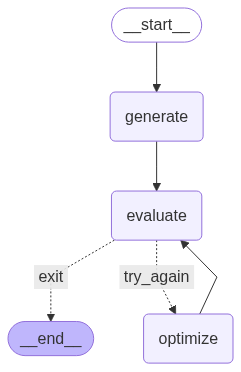

In [19]:
workflow = graph.compile()
workflow

In [11]:
init_state = {
    'topic' : "AI in bihar",
    'iteration' : 1,
    'max_iterations': 3   
}

In [20]:
result = workflow.invoke(init_state)
print("Final result:")
print(f"Topic: {result['topic']}")
print(f"Content: {result['content']}")
print(f"Evaluation: {result['evaluation']}")
print(f"Iterations completed: {result['iteration']}")
print(f"Feedback: {result['feedback']}")


Final result:
Topic: AI in bihar
Content: **Optimized Option 1:**

My Dadi's getting an AI crash course in Mithila painting! 😂  Wish me luck explaining the algorithm's "interpretation."  Pray for my sanity. 🙏 #AIinBihar #LittiChokhaAndAlgorithms  [Image: Mockup of Dadi side-eyeing a robot holding a Mithila painting upside down]


**Reasoning for Optimization:**

* **Enhanced Humor:** Added "crash course," "Wish me luck explaining the algorithm's 'interpretation'," and "Pray for my sanity" to heighten the humor and relatability.  The image suggestion is now *very* specific, maximizing the comedic potential.
* **Conciseness:** Slightly shortened for impact while retaining essential elements.
* **Focus on Visual:**  The image suggestion is crucial for this tweet's success.  The specific mockup idea plays directly into the humor and generational clash.



**Optimized Option 2 (If image isn't feasible):**

AI vs. Dadi's Mithila painting expertise!  Think a robot can decipher her symbolic ma